In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd

from pmf import PoissonMF
from numpy import linalg as LA
from scipy import sparse
from scipy.sparse import csr_matrix
import scipy.sparse as spLA
from scipy.sparse.linalg import spsolve
from causalrec import *
from numba import jit

%matplotlib inline

In [2]:
# Load raw data

# file_path = "C:/Users/kenny/Desktop/Spring 2021/CSE547_Project/data/MovieLens.training"
file_path = "data/MovieLens.training"

train_cols = ['user_id', 'item_id', 'rating', 'timestamp']
trainDf = pd.read_csv(file_path, sep='\t', lineterminator='\n')
trainDf.columns = train_cols
trainDf=trainDf.drop(["timestamp"], axis=1)

n_users = 943
n_movies = 1682

trainDf["user_id"] -= 1
trainDf["item_id"] -= 1

In [3]:
# Clean data and setup for estimation
data = load_data(trainDf, shape=(n_users, n_movies), colnames=['user_id', 'item_id', 'rating'])
print(data.shape)
data_imp = exp_to_imp(data, 0.5)
data_coo = data_imp.tocoo()
row_tr, col_tr = data_coo.row, data_coo.col

R = data.toarray()
I = np.zeros((n_users, n_movies))
for u, i in zip(np.array(trainDf["user_id"]), np.array(trainDf["item_id"])):
    I[u, i] = 1

(943, 1682)


In [4]:
# Exposure model
pf = PoissonMF(n_components=10, max_iter=100)
pf.fit(data, row_tr, col_tr)
pi, lamb = pf.Eb.copy(), pf.Et.T

print(pi.shape)
print(lamb.shape)

a_hat = np.matmul(pi,lamb.T)

(943, 10)
(1682, 10)


In [5]:
# Outcome model
loss, U, V, gamma = estimate_latent_features(R, I, a_hat, 943, 1682, 10, 0.001, 20)
R_hat = estimate_ratings(U, V, gamma, a_hat, I)

# Errors
R_hat_I = []
for n in range(len(trainDf)):
    u = trainDf["user_id"][n]
    i = trainDf["item_id"][n]
    R_hat_I.append(R_hat[u, i])
rmse = np.mean((trainDf["rating"] - R_hat_I)**2)
rmse

/Users/apara/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


0.4300913742944317

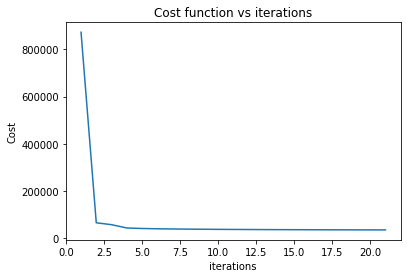

In [6]:
plt.plot(np.arange(1,len(loss)+1,1), loss)
plt.title('Cost function vs iterations')
plt.xlabel('iterations')
plt.ylabel('Cost')
plt.show()

## Tests on simulation

In [7]:
# Data simulation
n_users, n_items = 1000, 1000
K = 10

ydf, ydf_obs, Adf = simulate_data(0.5, 0.5, n_users, n_items, K)

data = load_data(ydf_obs, shape=(n_users, n_items), colnames=["uid", "sid", "rating"])
data_imp = exp_to_imp(data, 0.5)
data_coo = data_imp.tocoo()
row_tr, col_tr = data_coo.row, data_coo.col
R = data.toarray()
I = np.zeros((n_users, n_items))
for u, i in zip(np.array(ydf_obs["uid"]), np.array(ydf_obs["sid"])):
    I[u, i] = 1

In [8]:
# Exposure model
pf = PoissonMF(n_components=10, max_iter=100)
pf.fit(data, row_tr, col_tr)
pi, lamb = pf.Eb.copy(), pf.Et.T

print(pi.shape)
print(lamb.shape)

a_hat = np.matmul(pi,lamb.T)

(1000, 10)
(1000, 10)


In [9]:
# Outcome model
loss, U, V, gamma = estimate_latent_features(R, I, a_hat, n_users, n_items, 10, 0.001, 20)
R_hat = estimate_ratings(U, V, gamma, a_hat, I)

/Users/apara/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [10]:
# Errors
rmse = np.mean((ydf["rating"] - np.reshape(R_hat, (-1,)))**2)
print(rmse)

R_hat_I = []
for n in range(len(ydf_obs)):
    u = ydf_obs["uid"][n]
    i = ydf_obs["sid"][n]
    R_hat_I.append(R_hat[u, i])
rmse = np.mean((ydf_obs["rating"] - R_hat_I)**2)
print(rmse)

0.3021667126195204
0.14434738103998604
